# Problem B1: First autocorrelation inequality
For any function $f:\mathbb{R} \rightarrow \mathbb{R}$, define the *autoconvolution* of $f$, written $f*f$, as
$$f*f (t) := \int_\mathbb{R} f(t-x) f(x)\ dx.$$

Let $C_1$ denote the largest constant for which one has
\begin{equation}
 \max_{-1/2 \leq t \leq 1/2} f*f(t) \geq C_1 \left(\int_{-1/4}^{1/4} f(x)\ dx\right)^2
\end{equation}
for all non-negative $f: \mathbb{R} \rightarrow \mathbb{R}$.  This problem arises in additive combinatorics, relating to the size of Sidon sets.  It is currently known that
$$ 1.28 \leq C_1 \leq 1.5098$$
with the lower bound proven by [Cloninger and Steinerberger (2017)](https://www.ams.org/journals/proc/2017-145-08/S0002-9939-2017-13690-9/S0002-9939-2017-13690-9.pdf) and the upper bound achieved by [Matolcsi and Vinuesa (2010)](https://www.sciencedirect.com/science/article/pii/S0022247X10006001) via a step function construction. AlphaEvolve found a step function with 600 equally-spaced intervals on $[-1/4,1/4]$ that gives a better upper bound of $C_1 \leq 1.5053$.

## Compute the step function, the integral, and the autoconvolution

For step func. 
$$f(x) = \sum_{i=0}^{P-1} h_i \mathbf{1}_{[x_i, x_{i+1})}(x)$$  
where
$$ x_i = -\frac{1}{4} + \frac{i}{2P}, \text{ and heights } h_i \ge 0:$$
$$
\begin{aligned}
% Integral
\text{Integral:}\quad \int_{-1/4}^{1/4} f(x) \,dx &= \frac{1}{2P} \sum_{i=0}^{P-1} h_i
\\[2ex]
% Autoconvolution
\text{Autoconv. knots:}\quad (f*f)(t_m) &= 
\begin{cases} 
0 & \text{if } m=0 \text{ or } m=2P \\
\frac{1}{2P} \sum_{k=\max(0, m-P)}^{\min(P-1, m-1)} h_k h_{m-1-k} & \text{if } 1 \le m \le 2P-1
\end{cases}
\\[0.5ex]
&\quad \text{where } t_m = -\frac{1}{2} + \frac{m}{2P} \quad (m=0, \dots, 2P).
\end{aligned}
$$

## Plot the step function and the autoconvolution

--- Function Details (P=600) ---
Integral of f(x): 0.260772
Max value of autoconvolution (f*f)(t): 0.140667
Ratio max(f*f) / (integral(f))^2: 2.068570


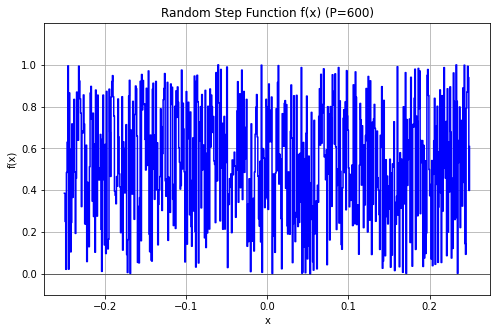

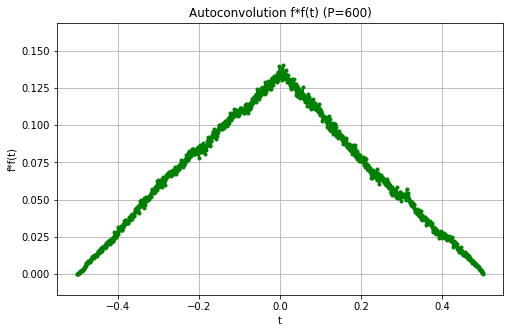

In [1]:
# script assumes 'compute_integral_of_step_function' and 'compute_autoconvolution_values'
# (from your previous code block) are already defined and executable in the notebook.
from utils import *

# --- main script logic ---
P_val = 600  # number of pieces for the step function
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val

# 1. sample random heights (non-negative)
# using float64 for precision, requires_grad=False for plotting/evaluation only
height_values = torch.rand(P_val, dtype=torch.float64) 
# for more structured/sparse functions, you could try:
# height_values = torch.abs(torch.randn(P_val, dtype=torch.float64)) * (torch.rand(P_val, dtype=torch.float64) > 0.7).double()


# 2. compute integral of f(x)
integral_value = compute_integral_of_step_function(height_values, f_delta_x)

# 3. compute autoconvolution (f*f)(t) knot values
# (2*P_val + 1) values for t_m from 2*f_x_min to 2*f_x_max
autoconv_knot_vals = compute_autoconvolution_values(height_values, f_delta_x, P_val)
max_autoconv_value = torch.max(autoconv_knot_vals)

# 4. calculate the ratio for C1 estimate
# (max f*f(t)) / (integral f(x) dx)^2
if integral_value.item() == 0:
    c1_ratio = float('inf') if max_autoconv_value.item() > 0 else 0.0 # handle division by zero
else:
    c1_ratio = max_autoconv_value / (integral_value**2)

print(f"--- Function Details (P={P_val}) ---")
# print(f"Heights (h_i, first 10): {height_values.numpy()[:10]}") # uncomment if you want to see heights
print(f"Integral of f(x): {integral_value.item():.6f}")
print(f"Max value of autoconvolution (f*f)(t): {max_autoconv_value.item():.6f}")
print(f"Ratio max(f*f) / (integral(f))^2: {c1_ratio.item():.6f}")


# 5. plotting
# plot f(x)
plot_rendered_step_function(height_values.numpy(), f_interval, title=f"Random Step Function f(x) (P={P_val})")

# plot f*f(t)
# autoconvolution is defined on [2*f_x_min, 2*f_x_max]
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals.numpy(), title=f"Autoconvolution f*f(t) (P={P_val})")



## Plotting Google's solution

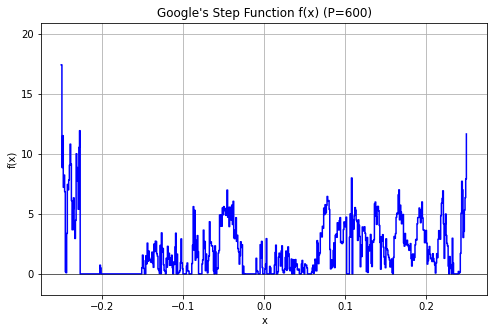

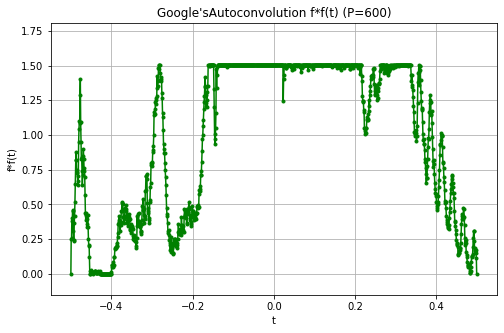

In [2]:
# Also plot google's solution
h_params_google = return_height_params_google_simplex()
autoconv_knot_vals_google = compute_autoconvolution_values(h_params_google, f_delta_x, P_val)
max_autoconv_value_google = torch.max(autoconv_knot_vals_google)

plot_rendered_step_function(h_params_google.detach().numpy(), f_interval, title=f"Google's Step Function f(x) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_google.detach().numpy(), title=f"Google'sAutoconvolution f*f(t) (P={P_val})")

## Algorithm 1: (Projected) Polyak subgradient method

The algorithm 
$$
h_+ = \mathrm{proj}_{\Delta_{2P}}\left(h - \frac{L(h) - L^*}{\| \nabla L(h) \|^2} \nabla L(h)\right)
$$
where $L^*$ is the target loss.

There is a subtlety here: we don't know what the optimal value is.

### Polyak with Random initialization

Iteration 0: loss = 2.0040850, step_size = 73.3796998, grad_norm = 0.0824706, min_loss_found_polyak = 2.004085
Best loss found: 1.5469582405231925


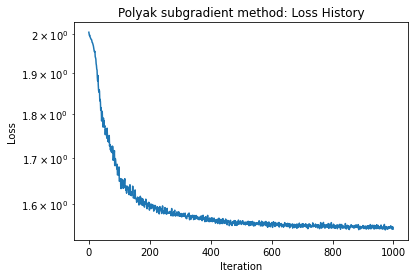

In [3]:
P_val = 600
# Initialize random height parameters
h_params_polyak = torch.rand(P_val, dtype=torch.float64)
h_params_polyak.requires_grad = True
# Define the projection and loss
def projection(x): 
    return projection_simplex_pytorch(x, 2*P_val)
h_params_polyak.data = projection(h_params_polyak.data)
loss_fn = constrained_loss(P_val)

# Setting up history
if 'history_polyak_constrained_random' not in locals():
    history_polyak_constrained_random = {}
else:
    h_params_polyak.data = history_polyak_constrained_random['best_h_params'].data.clone()

# Setting up parameters for Polyak
max_iter = 1000
target_loss = 1.505
print_every = 1000

history_polyak_constrained_random = polyak_subgradient_method(h_params_polyak,loss_fn, max_iter, target_loss, print_every, history_polyak_constrained_random, projection)
print("Best loss found:", history_polyak_constrained_random['min_loss_found'])
# semilogy plot of loss history
plt.semilogy(history_polyak_constrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()


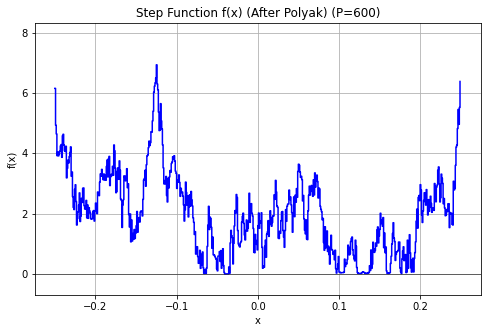

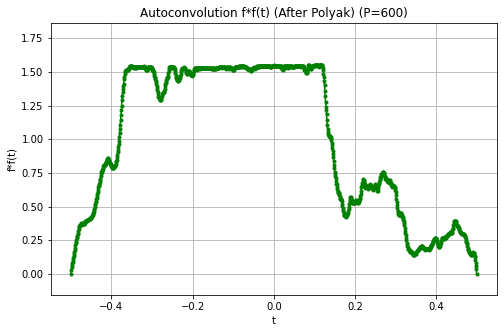

In [4]:
autoconv_knot_vals_polyak = compute_autoconvolution_values(history_polyak_constrained_random['best_h_params'], f_delta_x, P_val)
max_autoconv_value_polyak = torch.max(autoconv_knot_vals_polyak)

plot_rendered_step_function(history_polyak_constrained_random['best_h_params'].detach().numpy(), f_interval, title=f"Step Function f(x) (After Polyak) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_polyak.detach().numpy(), title=f"Autoconvolution f*f(t) (After Polyak) (P={P_val})")

torch.set_printoptions(precision=16, sci_mode=False)  # global setting
# need 16 digits of precision for the loss for the print statement to be correct

### Polyak started at the Google solution 

Iteration 0: loss = 1.5052943, step_size = 0.0002117, grad_norm = 0.1047444, min_loss_found_polyak = 1.505294
Best loss found (Google solution initialization): 1.505293369293213


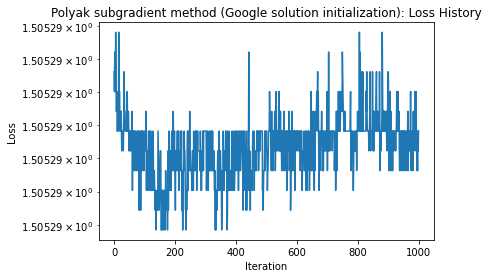

In [5]:
P_val = 600
h_params_polyak_google = h_params_google.data.detach().clone() # initialize variable at google's solution.
h_params_polyak_google.requires_grad = True
# Define the projection and loss
def projection(x): 
    return projection_simplex_pytorch(x, 2*P_val)
h_params_polyak_google.data = projection(h_params_polyak_google.data)
loss_fn = constrained_loss(P_val)

# Setting up history
if 'history_polyak_constrained_google' not in locals():
    history_polyak_constrained_google = {}
else:
    h_params_polyak_google.data = history_polyak_constrained_google['best_h_params'].data.clone()

max_iter = 1000
target_loss_google = 1.505292
print_every = 1000

history_polyak_constrained_google = polyak_subgradient_method(h_params_polyak_google, loss_fn, max_iter, target_loss_google, print_every, history_polyak_constrained_google, projection)

print("Best loss found (Google solution initialization):", history_polyak_constrained_google['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_polyak_constrained_google['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method (Google solution initialization): Loss History")
plt.show()


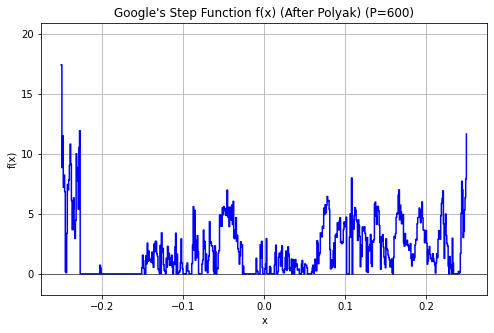

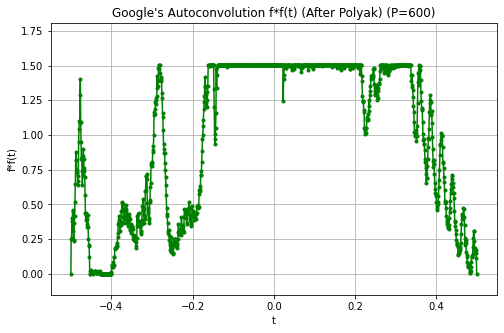

best_height_params_polyak_google tensor([   17.4101600646972656,     8.8549089431762695,    11.5087823867797852,
            7.2115802764892578,     8.2294750213623047,     6.8511590957641602,
            0.1715504229068756,     0.0950221568346024,     3.3703746795654297,
            7.4499421119689941,     6.9981336593627930,     7.8191924095153809,
            9.0487995147705078,    10.8042201995849609,     9.1564779281616211,
            6.1059794425964355,     3.6775650978088379,     5.3863077163696289,
            6.3343515396118164,     3.6684074401855469,     2.9492917060852051,
            4.4549655914306641,    10.0047130584716797,     8.8576641082763672,
            7.7132811546325684,     5.3816161155700684,    10.5341558456420898,
           11.9250411987304688,     0.0000045896726988,     0.0000061654700403,
            0.0000081271546151,     0.0000063876977947,     0.0000052476311794,
            0.0000021862222184,     0.0000075314937931,     0.0000053697449403,
       

In [6]:
# Also plot google's solution
autoconv_knot_vals_google_polyak = compute_autoconvolution_values(history_polyak_constrained_google['best_h_params'], f_delta_x, P_val)
max_autoconv_value_google_polyak = torch.max(autoconv_knot_vals_google_polyak)

plot_rendered_step_function(history_polyak_constrained_google['best_h_params'].detach().numpy(), f_interval, title=f"Google's Step Function f(x) (After Polyak) (P={P_val})")
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals_google_polyak.detach().numpy(), title=f"Google's Autoconvolution f*f(t) (After Polyak) (P={P_val})")

torch.set_printoptions(precision=16, sci_mode=False)  # global setting

print("best_height_params_polyak_google", history_polyak_constrained_google['best_h_params'])
# need 16 digits of precision for the loss for the print statement to be correct

## Changing the loss function to remove constraints

We're going to precompose the loss function with a softmax. This implicitly constrains the functions to the simplex. I.e., we will optimize

$$
L(2P\mathrm{softmax}(w))
$$


## Polyak on unconstrained (softmax) loss

Iteration 0: loss = 2.0096298, step_size = 192.3769761, grad_norm = 0.0504496, min_loss_found_polyak = 2.009630
Best loss found: 1.6355362903793431


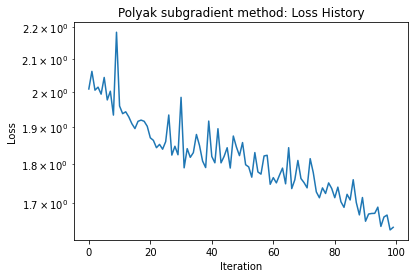

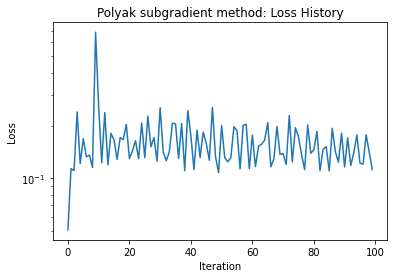

In [7]:

P_val = 600
h_params_polyak_unconstrained = torch.rand(P_val, dtype=torch.float64)
h_params_polyak_unconstrained.requires_grad = True

loss_f_softmax = unconstrained_loss(P_val)

if 'history_polyak_unconstrained_random' not in locals():
    history_polyak_unconstrained_random = {}
else:
    h_params_polyak.data = history_polyak_unconstrained_random['best_h_params'].data.clone()

max_iter = 100
target_loss = 1.52
print_every = 1000

history_polyak_unconstrained_random = polyak_subgradient_method(h_params_polyak_unconstrained, loss_f_softmax, max_iter, target_loss, print_every, history_polyak_unconstrained_random)

print("Best loss found:", history_polyak_unconstrained_random['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_polyak_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()

plt.semilogy(history_polyak_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Polyak subgradient method: Loss History")
plt.show()


## BFGS on unconstrained loss (with weak wolfe line search)
    


In [ ]:
P_val = 600
h_params_bfgs_unconstrained = torch.rand(P_val, dtype=torch.float64)
# h_params_bfgs_unconstrained = h_params_google # Start from google's solution if you want.
h_params_bfgs_unconstrained.data = torch.log(h_params_bfgs_unconstrained.data)
h_params_bfgs_unconstrained.requires_grad = True

loss_f_softmax = unconstrained_loss(P_val)

if 'history_bfgs_unconstrained_random' not in locals():
    history_bfgs_unconstrained_random = {}
else:
    h_params_bfgs_unconstrained.data = history_bfgs_unconstrained_random['best_h_params'].data.clone()

max_iter = 100000
bfgs_params = {}
bfgs_params['lr'] = 1
bfgs_params['history_size'] = 1000
bfgs_params['ls_params'] = {'c1': 0.0001, 'c2': 0.9}
# bfgs_params['line_search_fn'] = None # no line search function. Will likely blow up.
bfgs_params['line_search_fn'] = 'weak_wolfe' # good for later iterations
print_every = 100

history_bfgs_unconstrained_random = bfgs_method(h_params_bfgs_unconstrained, loss_f_softmax, max_iter, bfgs_params, print_every, history_bfgs_unconstrained_random)

print("Best loss found:", history_bfgs_unconstrained_random['min_loss_found'])

# semilogy plot of loss history
plt.semilogy(history_bfgs_unconstrained_random['loss_history'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("BFGS method: Loss History")
plt.show()

plt.semilogy(history_bfgs_unconstrained_random['grad_norm_history'])
plt.xlabel("Iteration")
plt.ylabel("grad norm")
plt.title("BFGS method: Loss History")
plt.show()

Iteration 0: loss = 2.0398363021, grad_norm = 0.1125456733, min_loss_found_bfgs = 2.0398363021
Iteration 100: loss = 1.8037667173, grad_norm = 0.1732653221, min_loss_found_bfgs = 1.8037667173
Iteration 200: loss = 1.7260108669, grad_norm = 0.2045914237, min_loss_found_bfgs = 1.7260108669
Iteration 300: loss = 1.6865082702, grad_norm = 0.2033124642, min_loss_found_bfgs = 1.6865082702
Iteration 400: loss = 1.6621998607, grad_norm = 0.1754875292, min_loss_found_bfgs = 1.6621998607
Iteration 500: loss = 1.6411786614, grad_norm = 0.3446422756, min_loss_found_bfgs = 1.6411786614
Iteration 600: loss = 1.6331036110, grad_norm = 0.1811559432, min_loss_found_bfgs = 1.6331036110
Iteration 700: loss = 1.6268964618, grad_norm = 0.2844515382, min_loss_found_bfgs = 1.6268964618
Iteration 800: loss = 1.6188303834, grad_norm = 0.1960921616, min_loss_found_bfgs = 1.6188303834
Iteration 900: loss = 1.6127842103, grad_norm = 0.2144446845, min_loss_found_bfgs = 1.6127842103
Iteration 1000: loss = 1.6087679